In [1]:
import os
import sys

import pickle
import numpy as np
import scipy
from scipy import optimize
from skimage import measure
import numpy.polynomial.polynomial as poly

import matplotlib as mpl
import matplotlib.pyplot as plt
import proplot as plot

current_path = !pwd
parent_path = os.path.dirname(current_path[0])
if parent_path not in sys.path: sys.path.append(parent_path)
root_path = "/".join(parent_path.split('/')[:-1])
if root_path not in sys.path: sys.path.append(root_path)
santi_path = root_path+"/santi_iso_response"
santi_etc_path = os.path.join(santi_path, 'etc')

import utils.model_handling as model_funcs
import utils.dataset_generation as iso_data
import utils.histogram_analysis as hist_funcs
import utils.plotting as plot_funcs

from santi_iso_response.iso_response import utils as santi_utils

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
width_fraction = 1.0
text_width = 540.60236 #pt
fontsize = 10
dpi = 300
file_extensions = ['.pdf']#, '.eps', '.png']
font_settings = {
        "text.usetex": True,
        "font.family": 'serif',
        "font.serif": 'Computer Modern Roman',
        "axes.labelsize": fontsize,
        "axes.titlesize": fontsize,
        "figure.titlesize": fontsize+2,
        "font.size": fontsize,
        "legend.fontsize": fontsize,
        "xtick.labelsize": fontsize-2,
        "ytick.labelsize": fontsize-2,
}
mpl.rcParams.update(font_settings)
rc_kwargs = {
    'fontsize':mpl.rcParams['font.size'],
    'fontfamily':mpl.rcParams['font.family'],
    'legend.fontsize':mpl.rcParams['font.size'],
    'text.labelsize':mpl.rcParams['font.size']
}

In [3]:
results_path = root_path+'/iso_analysis/'
save_prefix = 'santi'
params_file = results_path+save_prefix+'_stim_params.npz'
mei_curvature_file = results_path+save_prefix+'_meis.npz'
mes_curvature_file = results_path+save_prefix+'_stim.npz'
rand_curvature_file = results_path+save_prefix+'_rand.npz'

In [4]:
analysis_params = np.load(params_file, allow_pickle=True)['data'].item()
label_list = ["Neuron "+str(neuron_id) for neuron_id in analysis_params["target_neuron_ids"]]
print('\n'.join([f'{key}\t\t{val}' for key, val in analysis_params.items()]))

batch_size		100
target_neuron_ids		[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]
num_comparisons		160
min_angle		15
x_range		(-2.0, 2.0)
y_range		(-2.0, 2.0)
num_images		900
image_scale		12
target_activity		0.75
output_directory		/gpfs01/bethge/home/dpaiton/Work/iso_analysis/
save_prefix		santi_


In [5]:
mei_curvatures = np.load(mei_curvature_file, allow_pickle=True)['data'].item()
print('\n'.join([key for key in mei_curvatures.keys()]))

mei_lengths
contour_dataset
iso_curvatures
response_images
attn_curvatures
comparison_vecttor_ids
target_vectors
comparison_vectors


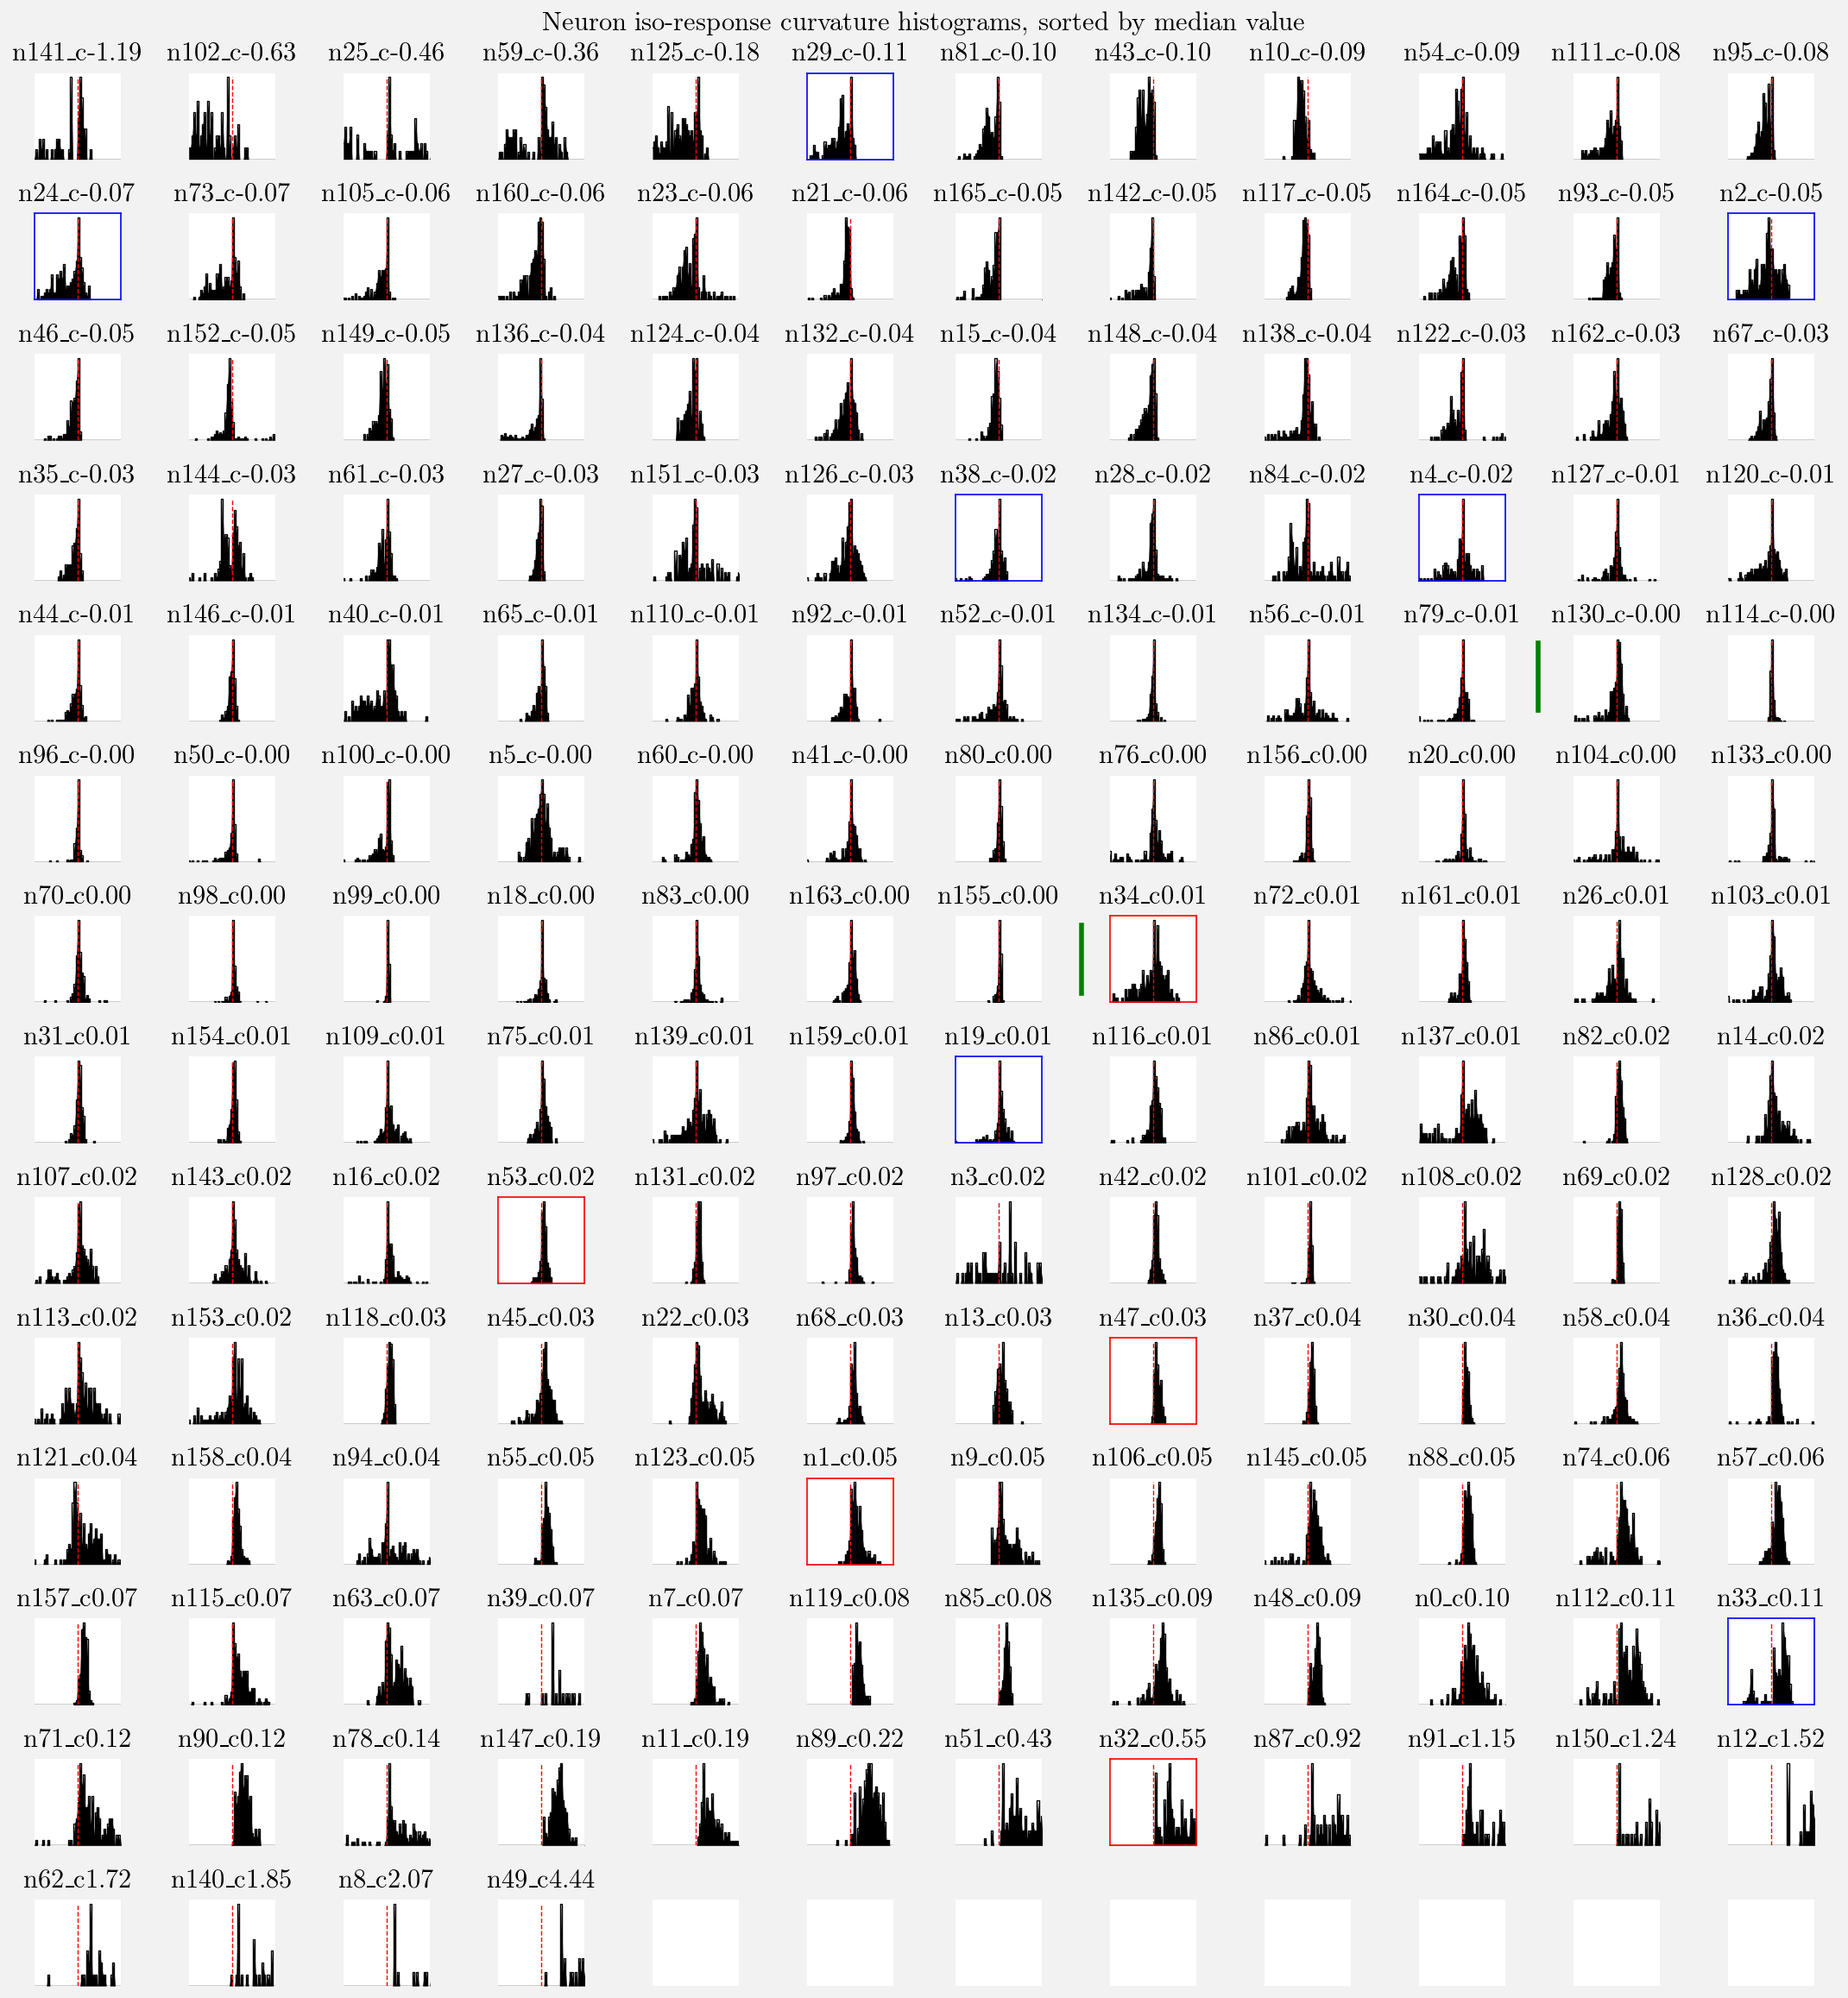

In [6]:
num_bins = 50

curvature_type = 'iso_curvatures'
#curvature_type = 'attn_curvatures'

num_neurons = len(mei_curvatures[curvature_type])

curvature_means = [np.mean(curvature) for curvature in mei_curvatures[curvature_type]]
curvature_medians = [np.median(curvature) for curvature in mei_curvatures[curvature_type]]
median_argsort = np.argsort(curvature_medians)

if(np.sqrt(num_neurons) == np.round(np.sqrt(num_neurons), 0)):
    num_neurons_edge = int(np.sqrt(num_neurons))
    nrows = num_neurons_edge
    ncols = num_neurons_edge
else:
    num_neurons_edge = int(np.sqrt(num_neurons))
    nrows = num_neurons // num_neurons_edge + 1
    ncols = num_neurons_edge

#test_bin_min = -0.13
#test_bin_max = 0.13
test_bin_min = -0.5
test_bin_max = 0.5

bins = hist_funcs.get_bins(num_bins, test_bin_min, test_bin_max)

axwidth = 0.5
fig, axes = plot.subplots(
    nrows=nrows,
    ncols=ncols,
    sharex=True,
    sharey=True,
    axwidth=axwidth)

simple_cell_ids = [1, 32, 34, 47, 53]
complex_cell_ids = [2, 4, 19, 24, 29, 33, 38]
plot_idx = 0
for row_idx in range(nrows):
    for col_idx in range(ncols):
        if plot_idx < num_neurons:
            unsort_idx = median_argsort[plot_idx]
            neuron_id = analysis_params['target_neuron_ids'][unsort_idx]
            if neuron_id in simple_cell_ids:
                ax = plot_funcs.clear_axis(axes[row_idx, col_idx], spines='r')
            elif neuron_id in complex_cell_ids:
                ax = plot_funcs.clear_axis(axes[row_idx, col_idx], spines='b')
            else:
                ax = plot_funcs.clear_axis(axes[row_idx, col_idx], spines='none')
            hist, bin_edges = hist_funcs.get_relative_hist(mei_curvatures[curvature_type][unsort_idx], bins)
            bin_lefts, bin_rights = bins[:-1], bins[1:]
            bin_centers = bin_lefts + (bin_rights - bin_lefts)
            ax.plot(bin_centers, hist, linestyle='-', drawstyle='steps-mid',
                color='k', linewidth=0.5, label=label_list[unsort_idx], zorder=1)
            ax.fill_between(bin_centers, 0, hist, color='k', zorder=2)
            ax.plot([0, 0], [0, np.max(hist)], color='r', linestyle='--', linewidth=0.5, zorder=3)
            ax.format(title=f'n{neuron_id}\_c{np.round(curvature_medians[unsort_idx], 2):0.2f}')
            if plot_idx >= 1:
                prev_unsort_idx = median_argsort[plot_idx-1]
                prev_curv_med = np.round(curvature_medians[prev_unsort_idx], 2)
                curr_curv_med = np.round(curvature_medians[unsort_idx], 2)
                x_offset = -0.08
                y_offset = -0.02
                if prev_curv_med < 0.00 and curr_curv_med >= 0.00:
                    pos = ax.get_position().get_points() # get the axis position in the form [[x0, y0], [x1, y1]]
                    xpos = [pos[1][0]+x_offset,]*2
                    ypos = [pos[0][1]+y_offset, pos[1][1]+y_offset]
                    ax.plot(xpos, ypos, color='g', lw=2, transform=fig.transFigure, clip_on=False)
                if prev_curv_med <= 0.0 and curr_curv_med > 0.0:
                    pos = ax.get_position().get_points() # get the axis position in the form [[x0, y0], [x1, y1]]
                    xpos = [pos[1][0]+x_offset,]*2
                    ypos = [pos[0][1]+y_offset, pos[1][1]+y_offset]
                    ax.plot(xpos, ypos, color='g', lw=2, transform=fig.transFigure, clip_on=False)
        else:
            ax = plot_funcs.clear_axis(axes[row_idx, col_idx])
        plot_idx += 1
axes.format(
    xlim=[test_bin_min, test_bin_max],
    suptitle='Neuron iso-response curvature histograms, sorted by median value'
    #suptitle='Neuron response attenuation curvature histograms, sorted by median value'
)
plot.show()

for extension in file_extensions:
    save_name = analysis_params['output_directory']+'iso_curvature_histograms'+extension
    #save_name = analysis_params['output_directory']+'attn_curvature_histograms'+extension
    fig.savefig(save_name, transparent=True, bbox_inches="tight", pad_inches=0.05, dpi=dpi)

In [7]:
#Some simple cells: 1, 32, 34, 47, 53. Some complex cells: 2, 4, 19, 24, 29, 33, 38
simple_cell_ids = [1, 32, 34, 47, 53]
complex_cell_ids = [2, 4, 19, 24, 29, 33, 38]
simple_medians = []
complex_medians = []
for list_index, neuron_id in enumerate(analysis_params['target_neuron_ids']):
    if neuron_id in simple_cell_ids:
        simple_medians.append(np.round(curvature_medians[list_index], 3))
    if neuron_id in complex_cell_ids:
        complex_medians.append(np.round(curvature_medians[list_index], 3))
print(f'simple median curvatures = {simple_medians}\ncomplex median curvatures = {complex_medians}')

simple median curvatures = [0.049, 0.545, 0.006, 0.035, 0.019]
complex median curvatures = [-0.047, -0.015, 0.01, -0.066, -0.107, 0.107, -0.023]


In [45]:
def argmed(array):
    array = np.array(array)
    med_idx = np.abs(array - np.median(array)).argmin()
    return med_idx

def add_arrow(ax, vect, xrange, x_y_offset, label, text_color='k'):
    arrow_width = 0.0
    arrow_linewidth = 1
    arrow_headsize = 0.15
    arrow_head_length = 0.15
    arrow_head_width = 0.15
    target_vector_x = vect[0].item()
    target_vector_y = vect[1].item()
    ax.arrow(0, 0, target_vector_x, target_vector_y,
        width=arrow_width, head_width=arrow_head_width, head_length=arrow_head_length,
        fc='k', ec='k', linestyle='-', linewidth=arrow_linewidth)
    tenth_range_shift = xrange/10 # For shifting labels
    text_handle = ax.text(
        target_vector_x+(tenth_range_shift*x_y_offset[0]),
        target_vector_y+(tenth_range_shift*x_y_offset[1]),
        label,
        weight='bold',
        color=text_color,
        horizontalalignment='center',
        verticalalignment='center'
    )

In [49]:
target_neuron_id = 137
activations = mei_curvatures['response_images'].copy()

num_target, num_planes, num_y, num_x = activations.shape 
x_pts, y_pts = (mei_curvatures['contour_dataset']['x_pts'], mei_curvatures['contour_dataset']['y_pts'])
x_range = max(x_pts) - min(x_pts)
y_range = max(y_pts) - min(y_pts)
x_scale_factor =  x_range / num_x
y_scale_factor =  y_range / num_y

iso_curvatures, iso_fits, iso_contours = hist_funcs.iso_response_curvature_poly_fits(
    activations,
    0.5,
    #analysis_params['target_activity'],
    [x_scale_factor, y_scale_factor],
    measure_loc='right')

min_idx = np.argmin(mei_curvatures['iso_curvatures'][target_neuron_id])
med_idx = argmed(mei_curvatures['iso_curvatures'][target_neuron_id])
max_idx = np.argmax(mei_curvatures['iso_curvatures'][target_neuron_id])
index_list = [min_idx, med_idx, max_idx]
curvatures_list = [mei_curvatures['iso_curvatures'][target_neuron_id][min_idx], mei_curvatures['iso_curvatures'][target_neuron_id][med_idx], mei_curvatures['iso_curvatures'][target_neuron_id][max_idx]] 
activations_list = []
for comp_idx in index_list:
    activations_list.append(np.squeeze(mei_curvatures['response_images'][target_neuron_id, comp_idx, ...]).copy())
    
#min_mean_max_index = 0
#comp_neuron_id = index_list[min_mean_max_index]

num_levels = 10


/gpfs01/bethge/home/dpaiton/.local/lib/python3.6/site-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


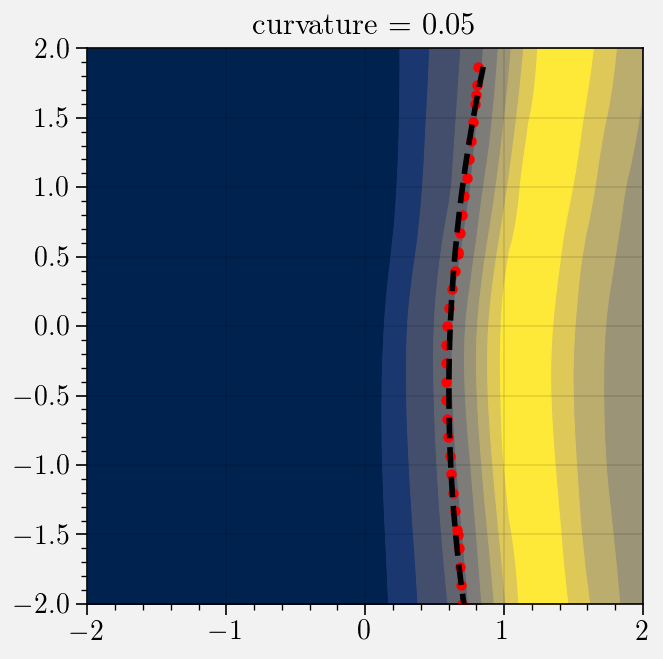

In [196]:
from skimage import measure
import numpy.polynomial.polynomial as poly

target_neuron_id = np.random.choice(range(activations.shape[0]))
comp_idx = np.random.choice(range(activations.shape[1]))

tmp_activity = activations[target_neuron_id, comp_idx, ...].copy()
num_y, num_x = tmp_activity.shape
x_pts, y_pts = (mei_curvatures['contour_dataset']['x_pts'], mei_curvatures['contour_dataset']['y_pts'])
x_range = max(x_pts) - min(x_pts)
y_range = max(y_pts) - min(y_pts)
x_scale_factor =  x_range / num_x
y_scale_factor =  y_range / num_y
xy_scale = [x_scale_factor, y_scale_factor]

tmp_activity[:, :num_x//2] = 0
contours = measure.find_contours(tmp_activity, 0.5)
bleh = np.concatenate(contours, axis=0)
x_contour_pts = bleh[:,1] * xy_scale[0] - (num_x * xy_scale[0] / 2)
y_contour_pts = bleh[:,0] * xy_scale[1] - (num_y * xy_scale[1] / 2)

coeffs = poly.polyfit(x=y_contour_pts, y=x_contour_pts, deg=2) 
fit_pts = (poly.polyval(y_contour_pts, coeffs), y_contour_pts)

fig, ax = plot.subplots()
contsf = ax.contourf(x_mesh, y_mesh, mei_curvatures['response_images'][target_neuron_id, comp_idx, ...],
    levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)
ax.scatter(x_contour_pts, y_contour_pts, s=10, color='r')
ax.plot(fit_pts[0], fit_pts[1], linewidth=2, linestyle='--', color='k')
ax.format(
    ylim = [np.min(y_pts), np.max(y_pts)],
    xlim = [np.min(x_pts), np.max(x_pts)],
    title=f'curvature = {np.round(coeffs[-1], 2)}'
)
plot.show()

/usr/local/lib/python3.6/dist-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


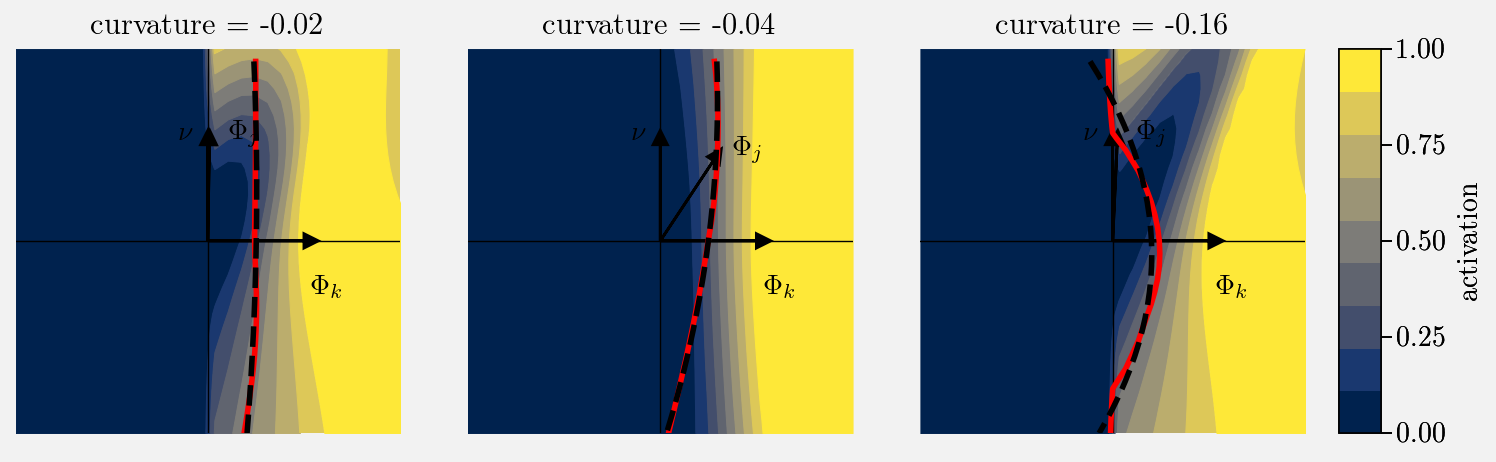

In [107]:
figsize = plot_funcs.set_size(text_width, fraction=width_fraction, subplot=[1, 2])
with plot.rc.context(**rc_kwargs):
    fig, axes = plot.subplots(nrows=1, ncols=len(activations_list), figsize=figsize)

for ax, activity, comp_neuron_id in zip(axes, activations_list, index_list):
    #activity = activations_list[target_neuron_id][comp_neuron_id]
    x_contour_pts, y_contour_pts = iso_contours[target_neuron_id][comp_neuron_id]
    coeffs_x, coeffs_y = iso_fits[target_neuron_id][comp_neuron_id]
    poly_curvature = iso_curvatures[target_neuron_id][comp_neuron_id]
    ax = plot_funcs.clear_axis(ax)
    vmin = np.min(activity)
    vmax = np.max(activity)
    cmap = plt.get_cmap('cividis')
    cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
    # Plot contours
    x_mesh, y_mesh = np.meshgrid(
        mei_curvatures['contour_dataset']['x_pts'],
        mei_curvatures['contour_dataset']['y_pts']
    )
    levels = np.linspace(vmin, vmax, num_levels)
    contsf = ax.contourf(x_mesh, y_mesh, activity,
        levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)
    # Add arrows
    proj_target = mei_curvatures['contour_dataset']['proj_target_vect'][0][comp_neuron_id]
    xrange = max(analysis_params['x_range']) - min(analysis_params['x_range'])
    tar_text_x_offset = 0.6 / width_fraction
    tar_text_y_offset = -1.2 / width_fraction
    label = r'$\Phi_{k}$'
    add_arrow(ax, proj_target, xrange, [tar_text_x_offset, tar_text_y_offset], label)
    proj_comparison = mei_curvatures['contour_dataset']['proj_comparison_vect'][0][comp_neuron_id]
    comp_text_x_offset = 0.9 / width_fraction
    comp_text_y_offset = 0.3 / width_fraction
    label = r'$\Phi_{j}$'
    add_arrow(ax, proj_comparison, xrange, [comp_text_x_offset, comp_text_y_offset], label)
    proj_orth = mei_curvatures['contour_dataset']['proj_orth_vect'][0][comp_neuron_id]
    orth_text_x_offset = -0.56 / width_fraction
    orth_text_y_offset = 0.3 / width_fraction
    label = r'$\nu$'
    add_arrow(ax, proj_orth, xrange, [orth_text_x_offset, orth_text_y_offset], label)
    # Add axis grid
    ax.set_aspect('equal')
    ax.plot(analysis_params['x_range'], [0,0], color='k', linewidth=1/2)
    ax.plot([0,0], analysis_params['y_range'], color='k', linewidth=1/2)
    ax.plot(x_contour_pts, y_contour_pts, linewidth=2, color='r')
    ax.plot(coeffs_x, coeffs_y, linewidth=2, linestyle='--', color='k')
    ax.format(
        ylim = [np.min(y_pts), np.max(y_pts)],
        xlim = [np.min(x_pts), np.max(x_pts)],
        title=f'curvature = {np.round(poly_curvature, 2)}'
    )
cb = axes[-1].colorbar(contsf, loc='r', label='activation', ticks=0.25)

for extension in file_extensions:
    save_name = analysis_params['output_directory']+f'iso_curvature_planes_n{target_neuron_id}'+extension
    fig.savefig(save_name, transparent=True, bbox_inches="tight", pad_inches=0.05, dpi=dpi)

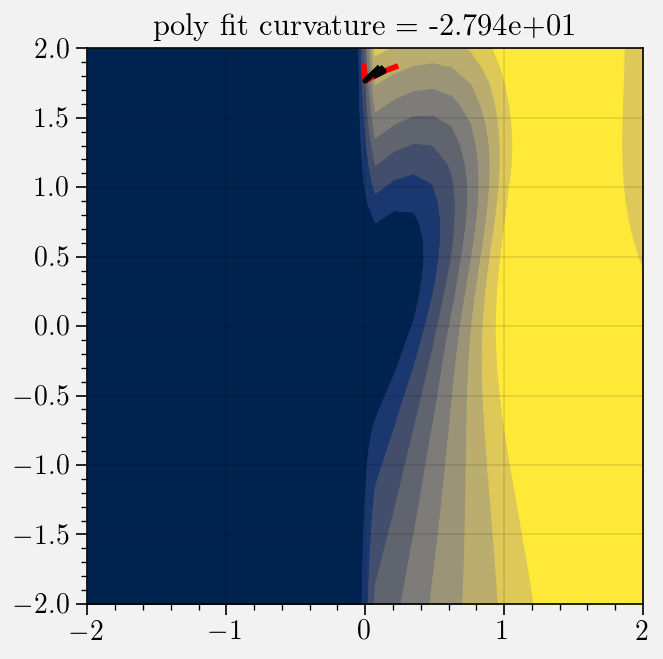

In [44]:

fig, ax = plot.subplots()
vmin = np.min(activity)
vmax = np.max(activity)
levels = np.linspace(vmin, vmax, num_levels)
cmap = plt.get_cmap('cividis')
cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
x_mesh, y_mesh = np.meshgrid(x_pts, y_pts)
contsf = ax.contourf(x_mesh, y_mesh, activity,
    levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)
ax.plot(x_contour_pts, y_contour_pts, linewidth=2, color='r')
ax.plot(coeffs_x, coeffs_y, linewidth=2, linestyle='--', color='k')
ax.format(
    ylim = [np.min(y_pts), np.max(y_pts)],
    xlim = [np.min(x_pts), np.max(x_pts)],
    title = f'poly fit curvature = {poly_curvature:.3e}'
)
plot.show()

In [ ]:
x = np.linspace(0, 10, 50)
y = 5 * x + 10 + (np.random.random(len(x)) - 0.5) * 5

plt.scatter(x, y,marker='.', label='Data for regression', color='b')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 
         label='numpy.polyfit', color='g')
plt.plot(np.unique(x), np.poly1d(poly.polyfit(x, y, 1)[::-1])(np.unique(x)), 
         label='polynomial.polyfit', color='k', linestyle='--')
plt.legend()
plt.show()

In [ ]:
x = x_pts
a = -8
b = 5
c = 0.5
y = a*x**2 + b*x + c + (np.random.random(len(x)) - 0.5) * 5

plt.scatter(x, y, marker='.', label='Data for regression', color='b')
coeffs = poly.polyfit(x, y, deg=2)
plt.plot(x, np.poly1d(coeffs[::-1])(x), label='ploty1d', color='r')
ffit = poly.Polynomial(coeffs)
plt.plot(x, ffit(x), linestyle='--', label='poly.Polynomial', color='k')
plt.title(f'a = {np.round(coeffs[2], 2)}, b={np.round(coeffs[1], 2)}, c={np.round(coeffs[0], 2)}')
plt.legend()
plt.show()

In [ ]:
x = x_contour_pts
y = y_contour_pts

plt.scatter(x, y, marker='.', label='Data for regression', color='b')

# polyfit assumes a certain orientation of the contour, where the convexity is in the y direction
coeffs = poly.polyfit(x=y, y=x, deg=2) 
plt.plot(np.poly1d(coeffs[::-1])(y), y, label='ploty1d', color='r')

ffit = poly.Polynomial(coeffs)
plt.plot(ffit(y), y, linestyle='--', label='poly.Polynomial', color='k')

plt.title(f'a = {np.round(coeffs[2], 2)}, b={np.round(coeffs[1], 2)}, c={np.round(coeffs[0], 2)}')
plt.legend()
plt.show()

In [ ]:
x_act = np.squeeze(activations[0, :])
closest_target_act = x_act[np.abs(x_act - target_act).argmin()] # find a location to take a slice
x_target_index = np.argwhere(x_act == closest_target_act)[0].item() # find the index along x axis
x_target = x_pts[x_target_index] # find the x value at this index
num_y, num_x = activations.shape
num_images = num_y * num_x
X_mesh, Y_mesh = np.meshgrid(x_pts, y_pts)
proj_datapoints = np.stack([X_mesh.reshape(num_images), Y_mesh.reshape(num_images)], axis=1)
slice_indices = np.where(proj_datapoints[:, 0] == x_target)[0]
slice_datapoints = proj_datapoints[slice_indices, :][:, :] # slice grid
slice_activity = activations.reshape([-1])[slice_indices][:]

x_vals = slice_datapoints[:,1]
y_vals = slice_activity * -1
plt.scatter(x_vals, y_vals, marker='.', label='Data for regression', color='b')
coeffs = poly.polyfit(x_vals, y_vals, deg=2) 
ffit = poly.polyval(x_vals, coeffs)
plt.plot(x_vals, ffit, linestyle='--', label='poly.Polynomial', color='k')
plt.title(f'a = {np.round(coeffs[2], 2)}, b={np.round(coeffs[1], 2)}, c={np.round(coeffs[0], 2)}')
plt.legend()
plt.show()

# polyfit assumes the convexity is up/down, while we will have left/right
# To get around this, we swap the x and y axis for the polyfit and then swap back
# polyfit returns [c0, c1, c2], where p = c0 + c1x + c2x^2
#coeffs = poly.polyfit(slice_datapoints[:, 1], sub_sliced_activity[-1], deg=2)
#sub_curvatures.append(coeffs[2])
#sub_fits.append(poly.polyval(slice_datapoints[:, 1], coeffs))

In [ ]:
target_act = 0.5
activations = activations_list[1]

num_y, num_x = activations.shape
x_pts = mei_curvatures['contour_dataset']['x_pts']
y_pts = mei_curvatures['contour_dataset']['y_pts']

x_range = max(x_pts) - min(x_pts)
y_range = max(y_pts) - min(y_pts)
x_scale_factor =  x_range / num_x
y_scale_factor =  y_range / num_y

contours = measure.find_contours(activations, target_act)[-1]

# rescale contour values to be within actual data range
x_contour_pts = contours[:,1] * x_scale_factor - (num_x * x_scale_factor / 2)
y_contour_pts = contours[:,0] * y_scale_factor - (num_y * y_scale_factor / 2)

fig, ax = plot.subplots()
vmin = np.min(activations)
vmax = np.max(activations)
cmap = plt.get_cmap('cividis')
cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)

x_mesh, y_mesh = np.meshgrid(x_pts, y_pts)
contsf = ax.contourf(x_mesh, y_mesh, activations,
    levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)

ax.plot(x_contour_pts, y_contour_pts, linewidth=2, color='r')

# Only use contour points for x > 0
x_pos = np.argwhere(x_contour_pts > 0)
y_contour_pts_half = np.squeeze(y_contour_pts[x_pos])
x_contour_pts_half = np.squeeze(x_contour_pts[x_pos])
coeffs = poly.polyfit(x=y_contour_pts_half, y=x_contour_pts_half, deg=2) # return coefficients in ascending order
#ffit = poly.Polynomial(coeffs)
#ax.plot(ffit(y_contour_pts_half), y_contour_pts_half, linewidth=2, linestyle='--', color='k')

ffit = poly.polyval(y_contour_pts_half, coeffs)
ax.plot(ffit, y_contour_pts_half, linewidth=2, linestyle='--', color='k')

poly_curvature = coeffs[-1]
ax.format(
    ylim = [np.min(y_pts), np.max(y_pts)],
    xlim = [np.min(x_pts), np.max(x_pts)],
    title = f'poly fit curvature = {poly_curvature:.3e}'
)
plot.show()

In [ ]:
class ComputeCurvature:
    def __init__(self):
        """ Initialize some variables """
        self.xc = 0  # X-coordinate of circle center
        self.yc = 0  # Y-coordinate of circle center
        self.r = 0   # Radius of the circle
        self.xx = np.array([])  # Data points
        self.yy = np.array([])  # Data points

    def calc_r(self, xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((self.xx-xc)**2 + (self.yy-yc)**2)

    def f(self, c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        ri = self.calc_r(*c)
        return ri - ri.mean()

    def df(self, c):
        """ Jacobian of f_2b
        The axis corresponding to derivatives must be coherent with the col_deriv option of leastsq"""
        xc, yc = c
        df_dc = np.empty((len(c), self.xx.size))

        ri = self.calc_r(xc, yc)
        df_dc[0] = (xc - self.xx)/ri                   # dR/dxc
        df_dc[1] = (yc - self.yy)/ri                   # dR/dyc
        df_dc = df_dc - df_dc.mean(axis=1)[:, np.newaxis]
        return df_dc

    def fit(self, xx, yy):
        self.xx = xx
        self.yy = yy
        center_estimate = np.r_[np.mean(xx), np.mean(yy)]
        center = optimize.leastsq(self.f, center_estimate, Dfun=self.df, col_deriv=True)[0]

        self.xc, self.yc = center
        ri = self.calc_r(*center)
        self.r = ri.mean()

        return 1 / self.r  # Return the curvature


# Apply code for an example curve
x = x_vals
y = y_vals
comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x, y)

# Generate points
theta_fit = np.linspace(-np.pi, np.pi, 180)
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_fit)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_fit)

# Plot the result
#plt.plot(x_fit, y_fit, 'k--', label='fit', lw=2)
#plt.plot(x, y, 'ro', label='data', ms=5, mec='b', mew=1)
#plt.xlabel('x')
#plt.ylabel('y')
#plt.title(f'curvature = {curvature:.3e} / poly = {poly_curvature:.3e}')
#plt.show()

In [ ]:
fig, ax = plot.subplots()
vmin = np.min(activations)
vmax = np.max(activations)
cmap = plt.get_cmap('cividis')
cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
x_mesh, y_mesh = np.meshgrid(x_pts, y_pts)
contsf = ax.contourf(x_mesh, y_mesh, activations,
    levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)
ax.plot(x_vals, y_vals, linewidth=2, color='r')
ffit = poly.Polynomial(coeffs)
ax.plot(x_vals, ffit(x_vals), linewidth=2, linestyle='--', color='g')
ax.plot(x_fit, y_fit, 'k--', label='fit', lw=2)
ax.format(
    ylim = analysis_params['y_range'],
    xlim = analysis_params['x_range'],
    title = f'circ = {curvature:.3e}\npoly = {poly_curvature:.3e}')
plot.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage as ndi
from skimage.feature import shape_index
from skimage.draw import disk

In [ ]:
def create_test_image(
        image_size=256, spot_count=30, spot_radius=5, cloud_noise_size=4):
    """
    Generate a test image with random noise, uneven illumination and spots.
    """
    state = np.random.get_state()
    np.random.seed(314159265)  # some digits of pi

    image = np.random.normal(
        loc=0.25,
        scale=0.25,
        size=(image_size, image_size)
    )

    for _ in range(spot_count):
        rr, cc = disk(
            (np.random.randint(image.shape[0]),
             np.random.randint(image.shape[1])),
            spot_radius,
            shape=image.shape
        )
        image[rr, cc] = 1

    image *= np.random.normal(loc=1.0, scale=0.1, size=image.shape)

    image *= ndi.zoom(
        np.random.normal(
            loc=1.0,
            scale=0.5,
            size=(cloud_noise_size, cloud_noise_size)
        ),
        image_size / cloud_noise_size
    )

    np.random.set_state(state)

    return ndi.gaussian_filter(image, sigma=2.0)

# First create the test image and its shape index

#image = create_test_image()
image = mei_curvatures['response_images'][target_neuron_id][min_idx]

s = shape_index(image)

# In this example we want to detect 'spherical caps',
# so we threshold the shape index map to
# find points which are 'spherical caps' (~1)

target = 1
delta = 0.05

point_y, point_x = np.where(np.abs(s - target) < delta)
point_z = image[point_y, point_x]

# The shape index map relentlessly produces the shape, even that of noise.
# In order to reduce the impact of noise, we apply a Gaussian filter to it,
# and show the results once in

s_smooth = ndi.gaussian_filter(s, sigma=0.5)

point_y_s, point_x_s = np.where(np.abs(s_smooth - target) < delta)
point_z_s = image[point_y_s, point_x_s]


fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)

ax1.imshow(image, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Input image')

scatter_settings = dict(alpha=0.75, s=10, linewidths=0)

ax1.scatter(point_x, point_y, color='blue', **scatter_settings)
ax1.scatter(point_x_s, point_y_s, color='green', **scatter_settings)

ax2 = fig.add_subplot(1, 3, 2, projection='3d', sharex=ax1, sharey=ax1)

x, y = np.meshgrid(
    np.arange(0, image.shape[0], 1),
    np.arange(0, image.shape[1], 1)
)

ax2.plot_surface(x, y, image, linewidth=0, alpha=0.5)

ax2.scatter(
    point_x,
    point_y,
    point_z,
    color='blue',
    label='$|s - 1|<0.05$',
    **scatter_settings
)

ax2.scatter(
    point_x_s,
    point_y_s,
    point_z_s,
    color='green',
    label='$|s\' - 1|<0.05$',
    **scatter_settings
)

ax2.legend(loc='lower left')

ax2.axis('off')
ax2.set_title('3D visualization')

ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)

h = ax3.imshow(s, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Shape index, $\sigma=1$')
fig.colorbar(h)

fig.tight_layout()

plt.show()

In [ ]:
image.shape

In [ ]:
mei_curvatures['response_images'].shape